In [1]:
%load_ext autoreload
%autoreload 2

# Load data

In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from scripts.filter_utils import *
import re

In [3]:
experiment_table, sample_df, replicate_df = load_experiment_manifest()
samples = experiment_table['sample'].tolist()

In [4]:
def load_gtf_annotations(gtf_path=GTF_FILE, features=['start_codon', 'CDS', 'UTR']):
    annotation_tables = []
    if isinstance(features, str):
        features = [features]
    for feature in features:
        print(f'Reading {feature}s from {gtf_path}')
        annotation_tables.append(load_transcript_annotations(gtf_path=gtf_path, feature_type=feature))
    if len(annotation_tables) == 1:
        return annotation_tables[0]
    else:
        return annotation_tables

gtf_annotations = load_gtf_annotations()
start_codon_annotations, cds_annotations, utr_annotations = gtf_annotations

Reading start_codons from /lab/barcheese01/aTIS_data/ribotish/gencode.v49.primary_assembly.annotation.gtf
Reading CDSs from /lab/barcheese01/aTIS_data/ribotish/gencode.v49.primary_assembly.annotation.gtf
Reading UTRs from /lab/barcheese01/aTIS_data/ribotish/gencode.v49.primary_assembly.annotation.gtf


In [5]:
transcript_to_genome_pos = get_canonical_genome_positions(cds_annotations=cds_annotations)
transcript_to_utr_length = get_utr_lengths(cds_annotations=cds_annotations, utr_annotations=utr_annotations)
transcript_to_start_codon = get_start_codons(start_codon_annotations=start_codon_annotations, genome_file=GENOME_FILE)
transcript_to_protein = get_protein_products(protein_fasta=PROTEIN_FASTA)

100%|██████████| 221201/221201 [00:23<00:00, 9454.84it/s]


Reading protein sequences from /lab/barcheese01/smaffa/coTISja/data/reference/gencode.v49.pc_translations.fa


In [6]:
LOAD_SEQUENCES = True
sequences = ['AASeq'] #['Seq', 'AASeq']

sample_to_filtered_tis = dict()

for sample in tqdm(samples):
    filt_table = pd.read_csv(experiment_table.set_index('sample').loc[sample, 'filtered_file'])

    # add undetected canonical start codons
    imputed_table = impute_missing_canonical_starts(
        filt_table, 
        genome_pos=transcript_to_genome_pos, 
        utr_lengths=transcript_to_utr_length, 
        start_codons=transcript_to_start_codon,
        protein_products=transcript_to_protein
    )

    # combine with the detected TISs
    filt_table = pd.concat([
        filt_table, imputed_table
    ], axis=0, ignore_index=True)
    filt_table['Imputed'] = filt_table['Imputed'].fillna(False)

    if LOAD_SEQUENCES:
        pred_table = pd.read_csv(experiment_table.set_index('sample').loc[sample, 'predict_file'], sep='\t', usecols=['Tid', 'GenomePos', 'Start'] + sequences)
        # pull AA translations for the non-canonical TISs from the ribotish outputs
        merged_table = filt_table.merge(pred_table, left_on=['Tid', 'GenomePos', 'Start'], right_on=['Tid', 'GenomePos', 'Start'], how='left')

        # pull AA translations for the canonical TISs from the protein annotations
        merged_table.loc[
            merged_table['Imputed'], 'AASeq'
        ] = transcript_to_protein.set_index('Tid').reindex(
            index=merged_table[merged_table['Imputed']]['Tid'].tolist()
        )['AASeq'].tolist()
    else:
        merged_table = filt_table
    sample_to_filtered_tis[sample] = merged_table
all_tis_df= pd.concat(sample_to_filtered_tis, axis=0).reset_index(names=['Sample', 'drop']).drop(['drop'], axis=1)

100%|██████████| 6/6 [06:55<00:00, 69.28s/it]


In [10]:
all_tis_df['IsoformID'] = all_tis_df['Tid'] + ':' + all_tis_df['Start'].astype(int).astype(str)
all_tis_df['TIS_ID'] = all_tis_df['Gid'] + ':' + all_tis_df['GenomeStart']
isoform_annotation_df = all_tis_df[['IsoformID', 'Tid', 'Symbol', 'GenomePos', 'Start', 'StartCodon', 'RecatTISType', 'MANE_Select', 'transcript_support_level']].drop_duplicates()
tis_annotation_df = all_tis_df[['TIS_ID', 'Tid', 'Symbol', 'GenomePos', 'Start', 'StartCodon', 'RecatTISType', 'MANE_Select', 'transcript_support_level']].drop_duplicates()

In [11]:
all_tis_df[all_tis_df['MANE_Select']].to_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_filtered_mane_only.csv', index=False)
all_tis_df.drop(['AASeq'], axis=1).to_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_filtered.csv', index=False)
all_tis_df.to_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_filtered_with_protein_seq.csv', index=False)

In [ ]:
all_tis_df = pd.read_csv('/lab/barcheese01/smaffa/coTISja/data/filtered_tis_data/combined/all_samples_filtered_with_protein_seq.csv')
isoform_annotation_df = all_tis_df[['IsoformID', 'Tid', 'Symbol', 'GenomePos', 'Start', 'StartCodon', 'RecatTISType', 'MANE_Select', 'transcript_support_level']].drop_duplicates()
genomic_tis_annotation_df = all_tis_df[['TIS_ID', 'Symbol', 'StartCodon']].drop_duplicates()
gene_annotation_df = all_tis_df[['Gid', 'Symbol']].drop_duplicates()

isoform_to_tis = all_tis_df[['IsoformID', 'TIS_ID']].drop_duplicates()
isoform_to_gene = all_tis_df[['IsoformID', 'Gid']].drop_duplicates()
tis_to_gene = all_tis_df[['TIS_ID', 'Gid']].drop_duplicates()

In [61]:
# TIS joined variables:
# NOTE: TISs are counted by their mapping to TRANSCRIPTS, but this aggregation is over unique GENOMIC TISs; i.e. there may be TISs at the same genomic locus with different count values
genomic_tis_concat_fields = all_tis_df.assign(
    Start=lambda x: x['Start'].astype(int).astype(str), 
    AALen=lambda x: x['AALen'].astype(int).astype(str),
    MANE_Select=lambda x: x['MANE_Select'].astype(str),
    transcript_support_level=lambda x: x['transcript_support_level'].apply(lambda y: 'None' if np.isnan(y) else str(int(y))),
    Imputed=lambda x: x['Imputed'].astype(str)
).groupby(
    ['Sample', 'TIS_ID', 'Gid', 'GenomeStart', 'TISCounts'])[
        ['IsoformID', 'Tid', 'TisType', 'RecatTISType', 'Start', 'AALen', 'MANE_Select', 'transcript_support_level', 'Imputed']
    ].agg(lambda x: '|'.join(list(x)))

# numeric fields that can be aggregated (we keep counts separate because transcripts are mapped separately - downstream analysis on genomic sites will likely want to remove imputed sites and average over mapped sites)
genomic_tis_agg_fields = all_tis_df.groupby(['Sample', 'TIS_ID', 'Gid', 'GenomeStart', 'TISCounts'])[['NormTISCounts']].mean()

# merge tables together
genomic_tis_df = genomic_tis_concat_fields.reset_index().merge(genomic_tis_agg_fields.reset_index()).merge(
    genomic_tis_annotation_df, left_on='TIS_ID', right_on='TIS_ID'
    ).loc[
    :, [
        'Sample', 'TIS_ID', 'Gid', 'Symbol', 'GenomeStart', 'StartCodon', 'TISCounts', 'NormTISCounts', 
        'IsoformID', 'TisType', 'RecatTISType', 'Start', 'AALen', 'Tid', 'MANE_Select', 'transcript_support_level', 'Imputed'
    ]
]

Text(0.5, 1.0, '# Uniquely mapped TIS per sample')

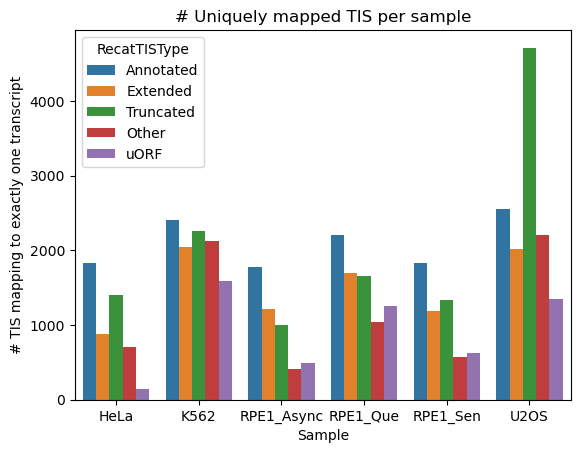

In [71]:
sns.countplot(
    genomic_tis_df[~genomic_tis_df['IsoformID'].str.contains('\|') & (genomic_tis_df['Imputed'] == 'False')],
    x='Sample', hue='RecatTISType'
)
plt.ylabel('# TIS mapping to exactly one transcript')
plt.title('# Uniquely mapped TIS per sample')

In [ ]:
# from Bio import SeqIO

# gencode_transcript_sequences = dict()
# for record in SeqIO.parse('/lab/barcheese01/smaffa/coTISja/data/reference/gencode.v49.pc_transcripts.fa', format='fasta'):
#     sequence_ids = record.id
#     transcript_id = [tag for tag in sequence_ids.split('|') if 'ENST' in tag][0]
#     gencode_transcript_sequences[transcript_id] = str(record.seq)
# gencode_transcript_sequences = pd.DataFrame(pd.Series(gencode_transcript_sequences), columns=['Seq']).reset_index(names=['Tid'])
# gencode_transcript_sequences['Len'] = gencode_transcript_sequences['Seq'].apply(lambda x: len(x))
# gencode_transcript_sequences

# Some global summary statistics

In [78]:
# take averages over all TIS positions in the genome - aggregation is over unique transcript mappings (proxied only by different counts)
raw_tis_counts_matrix = genomic_tis_df.pivot_table(index='Sample', columns='TIS_ID', values='TISCounts', aggfunc=np.sum).fillna(0)
norm_tis_counts_matrix = genomic_tis_df.pivot_table(index='Sample', columns='TIS_ID', values='NormTISCounts', aggfunc=np.sum).fillna(0)

# take averages over all isoforms (TIS for specific transcripts) - aggregation function should be irrelevant
raw_isoform_counts_matrix = all_tis_df.pivot_table(index='Sample', columns='IsoformID', values='TISCounts', aggfunc=np.mean).fillna(0)
norm_isoform_counts_matrix = all_tis_df.pivot_table(index='Sample', columns='IsoformID', values='NormTISCounts', aggfunc=np.mean).fillna(0)

## Gene level

In [ ]:
any_gene_translation_norm_count_matrix = norm_tis_counts_matrix.T.merge(
    genomic_tis_annotation_df[['TIS_ID', 'Symbol']], left_index=True, right_on='TIS_ID', how='inner'
).groupby('Symbol')[samples].sum().T

# annotated_translation_norm_count_matrix = norm_tis_counts_matrix.T.merge(
#     genomic_tis_annotation_df[genomic_tis_annotation_df['RecatTISType'] == 'Annotated'].loc[:, ['TIS_ID', 'Symbol']], left_index=True, right_on='TIS_ID', how='inner'
# ).groupby('Symbol')[samples].sum().T
# noncanonical_translation_norm_count_matrix = norm_tis_counts_matrix.T.merge(
#     genomic_tis_annotation_df[genomic_tis_annotation_df['RecatTISType'] != 'Annotated'].loc[:, ['TIS_ID', 'Symbol']], left_index=True, right_on='TIS_ID', how='inner'
# ).groupby('Symbol')[samples].sum().T

# canonical_count_fraction = (
#     annotated_translation_norm_count_matrix.reindex_like(any_gene_translation_norm_count_matrix).fillna(0) / 
#     any_gene_translation_norm_count_matrix
# )

### How does start codon usage vary between cell lines?

Text(0.5, 1.0, 'Relative start codon usage')

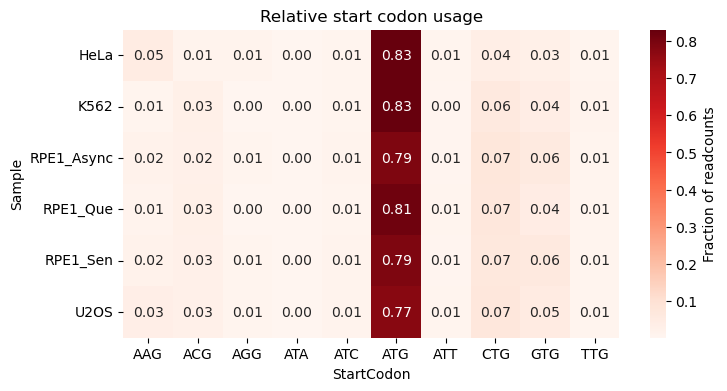

In [16]:
start_codon_usage = all_tis_df.pivot_table(index='Sample', columns='StartCodon', values='NormTISCounts', aggfunc=np.sum)
plt.figure(figsize=(8, 4))
sns.heatmap(
    (start_codon_usage.T / start_codon_usage.sum(axis=1)).T, cmap='Reds', annot=True, fmt='.2f', cbar_kws={'label': 'Fraction of readcounts'}
)
plt.title('Relative start codon usage')

### What is the relative balance of canonical/non-canonical translation initiation change across genes and across cell lines?

Text(0.5, 0, 'Fraction of counts per gene at canonical TIS')

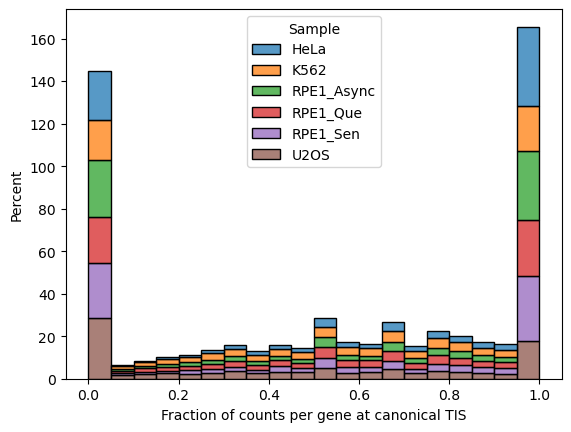

In [63]:
sns.histplot(
    canonical_count_fraction.melt(ignore_index=False).reset_index(names=['Sample']),
    x='value', hue='Sample', binwidth=0.05, multiple='stack', stat='percent', common_norm=False, legend=True
)
plt.xlabel('Fraction of counts per gene at canonical TIS')

### Of the genes with purely noncanonical translation, are the start codons enriched for any feature? 

In [79]:
tis_subsets = dict()
for s in samples:
    tis_subsets[f'{s}:Canonical=0'] = all_tis_df[
        (all_tis_df['Sample'] == s) &
        all_tis_df['Symbol'].isin(canonical_count_fraction.loc[s, canonical_count_fraction.loc[s] == 0].index.tolist()) &
        (~all_tis_df['Imputed'])
    ]
    tis_subsets[f'{s}:Background'] = all_tis_df[
        (all_tis_df['Sample'] == s) &
        (all_tis_df['RecatTISType'] != 'Annotated')
    ]

In [92]:
def plot_tis_type_distribution(subset_dict, hue='RecatTISType', **plot_kws):
    tis_to_plot = pd.concat(subset_dict).reset_index(names=['Group', 'drop'])
    sns.histplot(
        tis_to_plot, x='Group', hue=hue, stat='proportion', multiple='fill', shrink=0.8, **plot_kws
    )
    plt.xticks(rotation=90)
    return plt.gca()

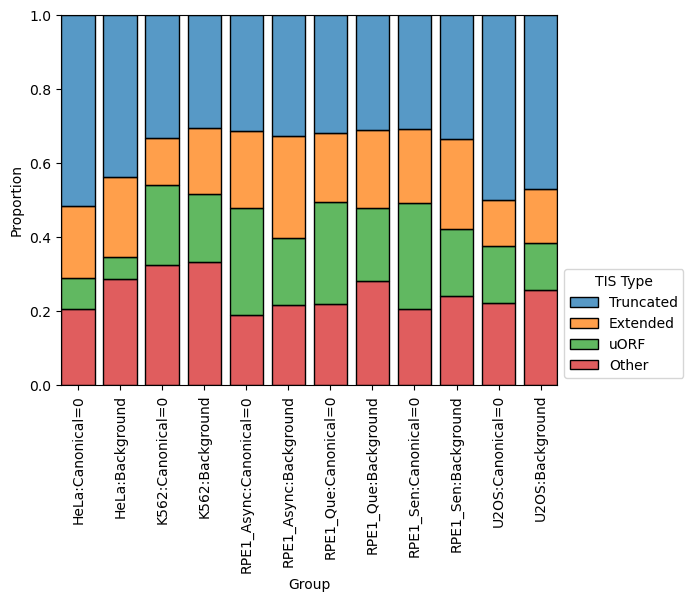

In [93]:
ax = plot_tis_type_distribution(tis_subsets, hue='RecatTISType', hue_order=['Truncated', 'Extended', 'uORF', 'Other'])
ax.get_legend().set_title('TIS Type')
ax.get_legend().set_loc(loc='lower left')
ax.get_legend().set_bbox_to_anchor((1, 0))

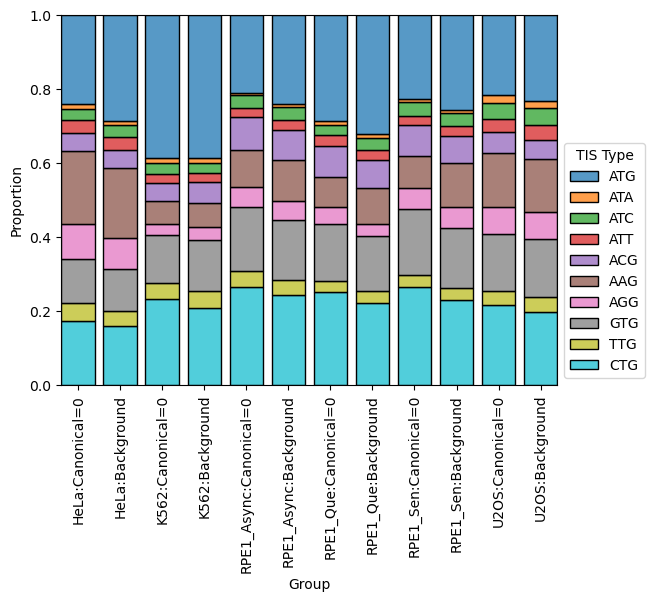

In [95]:
ax = plot_tis_type_distribution(tis_subsets, hue='StartCodon', hue_order=['ATG', 'ATA', 'ATC', 'ATT', 'ACG', 'AAG', 'AGG', 'GTG', 'TTG', 'CTG'])
ax.get_legend().set_title('TIS Type')
ax.get_legend().set_loc(loc='lower left')
ax.get_legend().set_bbox_to_anchor((1, 0))

<Axes: xlabel='AALen', ylabel='Sample'>

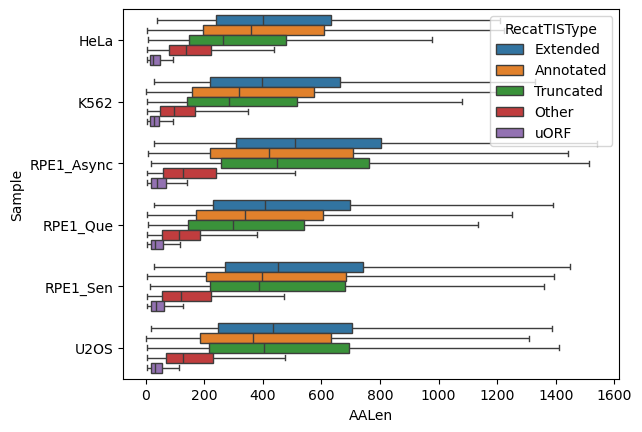

In [98]:
sns.boxplot(
    all_tis_df, x='AALen', y='Sample', hue='RecatTISType', dodge=True, showfliers=False, hue_order=['Extended', 'Annotated', 'Truncated', 'Other', 'uORF']
)

In [55]:
wide_canonical_to_noncanonical = pd.concat({
    'Canonical': annotated_translation_norm_count_matrix.reindex_like(any_gene_translation_norm_count_matrix).fillna(0),
    'Non-canonical': noncanonical_translation_norm_count_matrix.reindex_like(any_gene_translation_norm_count_matrix).fillna(0)
})

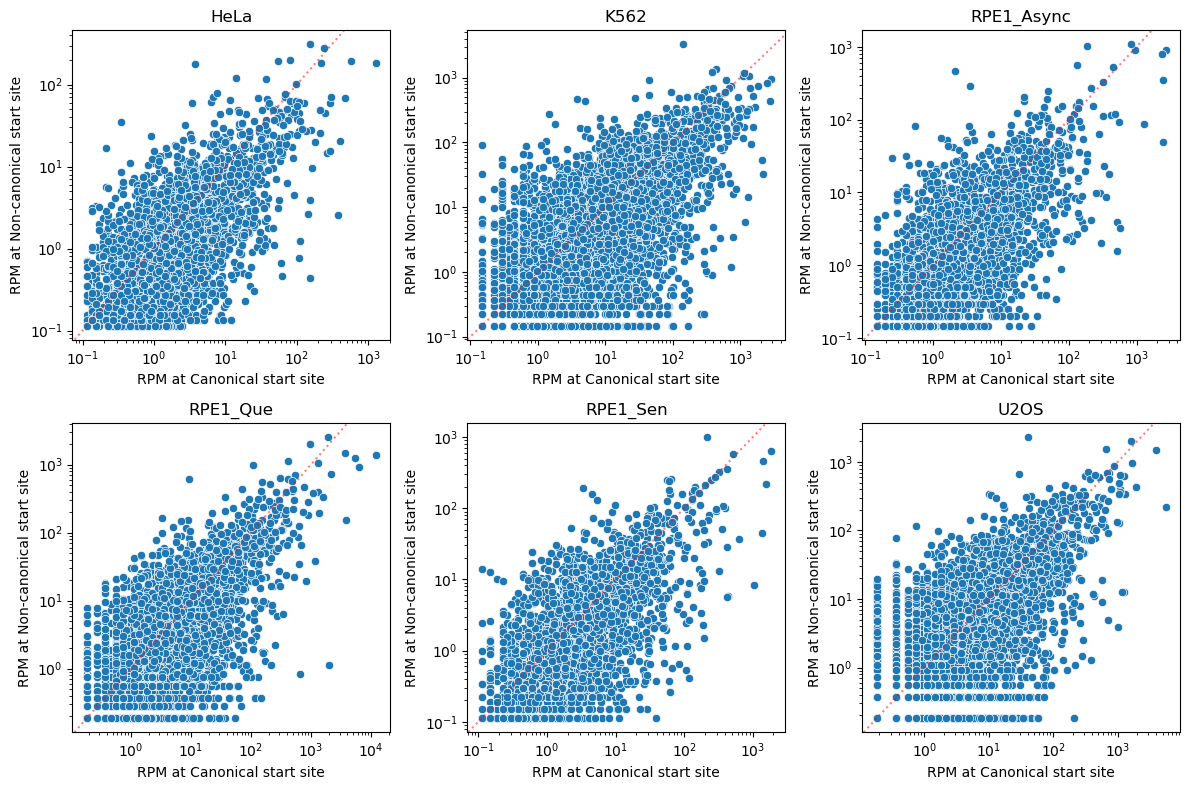

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for i, s in enumerate(samples):
    df = wide_canonical_to_noncanonical.loc[pd.IndexSlice[:, s], :].droplevel(1, axis=0).T
    df = df[df.sum(axis=1) > 0]
    sns.scatterplot(
        df, x='Canonical', y='Non-canonical', ax=axs[i], zorder=0
    )
    # sns.kdeplot(
    #     df, x='Canonical', y='Non-canonical', color='tab:red', ax=axs[i]
    # )
    axs[i].axline((0,0), slope=1, linestyle='dotted', color='red', alpha=0.5, zorder=1)
    axs[i].set_xlabel('RPM at Canonical start site')
    axs[i].set_ylabel('RPM at Non-canonical start site')
    axs[i].set_xscale('log', base=10)
    axs[i].set_yscale('log', base=10)
    axs[i].set_title(s)
plt.suptitle('Gene-level non-canonical vs canonical translation')
plt.tight_layout()
plt.show()

## Transcript level

In [10]:
any_transcript_translation_norm_count_matrix = norm_tis_counts_matrix.T.merge(
    tis_annotation_df[['TIS_ID', 'Tid']], left_index=True, right_on='TIS_ID', how='inner'
).groupby('Tid')[samples].sum().T

canonical_transcript_translation_norm_count_matrix = norm_tis_counts_matrix.T.merge(
    tis_annotation_df[tis_annotation_df['RecatTISType'] == 'Annotated'][['TIS_ID', 'Tid']], left_index=True, right_on='TIS_ID', how='inner'
).groupby('Tid')[samples].sum().T
noncanonical_transcript_translation_norm_count_matrix = norm_tis_counts_matrix.T.merge(
    tis_annotation_df[tis_annotation_df['RecatTISType'] != 'Annotated'][['TIS_ID', 'Tid']], left_index=True, right_on='TIS_ID', how='inner'
).groupby('Tid')[samples].sum().T

canonical_transcript_count_fraction = (
    canonical_transcript_translation_norm_count_matrix.reindex_like(any_transcript_translation_norm_count_matrix).fillna(0) / 
    any_transcript_translation_norm_count_matrix
)

Text(0.5, 0, 'Fraction of counts per transcript at canonical TIS')

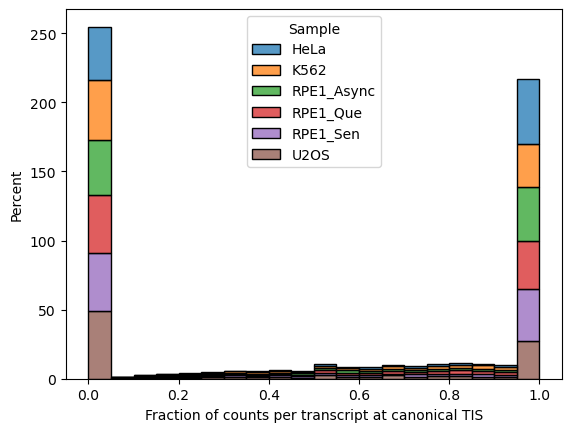

In [106]:
sns.histplot(
    canonical_transcript_count_fraction.melt(ignore_index=False).reset_index(names=['Sample']),
    x='value', hue='Sample', binwidth=0.05, multiple='stack', stat='percent', common_norm=False, legend=True
)
plt.xlabel('Fraction of counts per transcript at canonical TIS')

Why is this different than at the gene level? Suggests that per transcript, the relative isoform expression is closer to all-or-nothing, even if per gene, certain transcripts might have canonical translation while others are non-canonical

### How unique are the TISs to each cell line?

In [26]:
import upsetplot

Text(0, 0.5, 'Number of start sites')

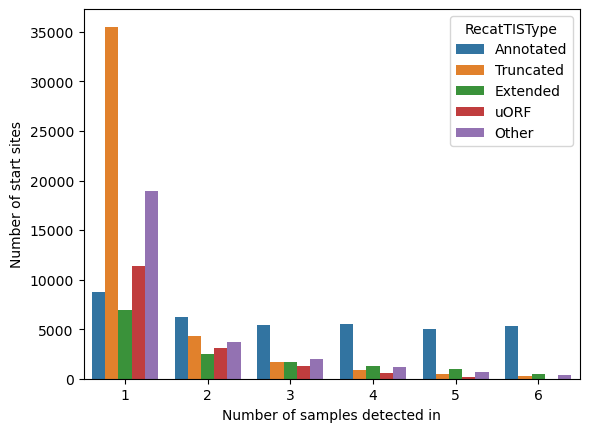

In [12]:
sns.countplot(
    all_tis_df.groupby(['TIS_ID', 'RecatTISType'])['Sample'].nunique().reset_index(),
    x='Sample', hue='RecatTISType'
)
plt.xlabel('Number of samples detected in')
plt.ylabel('Number of start sites')
# plt.savefig('/lab/barcheese01/smaffa/coTISja/data/figures/start_site_uniqueness.png')

In [25]:
memberships = all_tis_df.groupby('TIS_ID').apply(lambda x: list(x['Sample']))

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

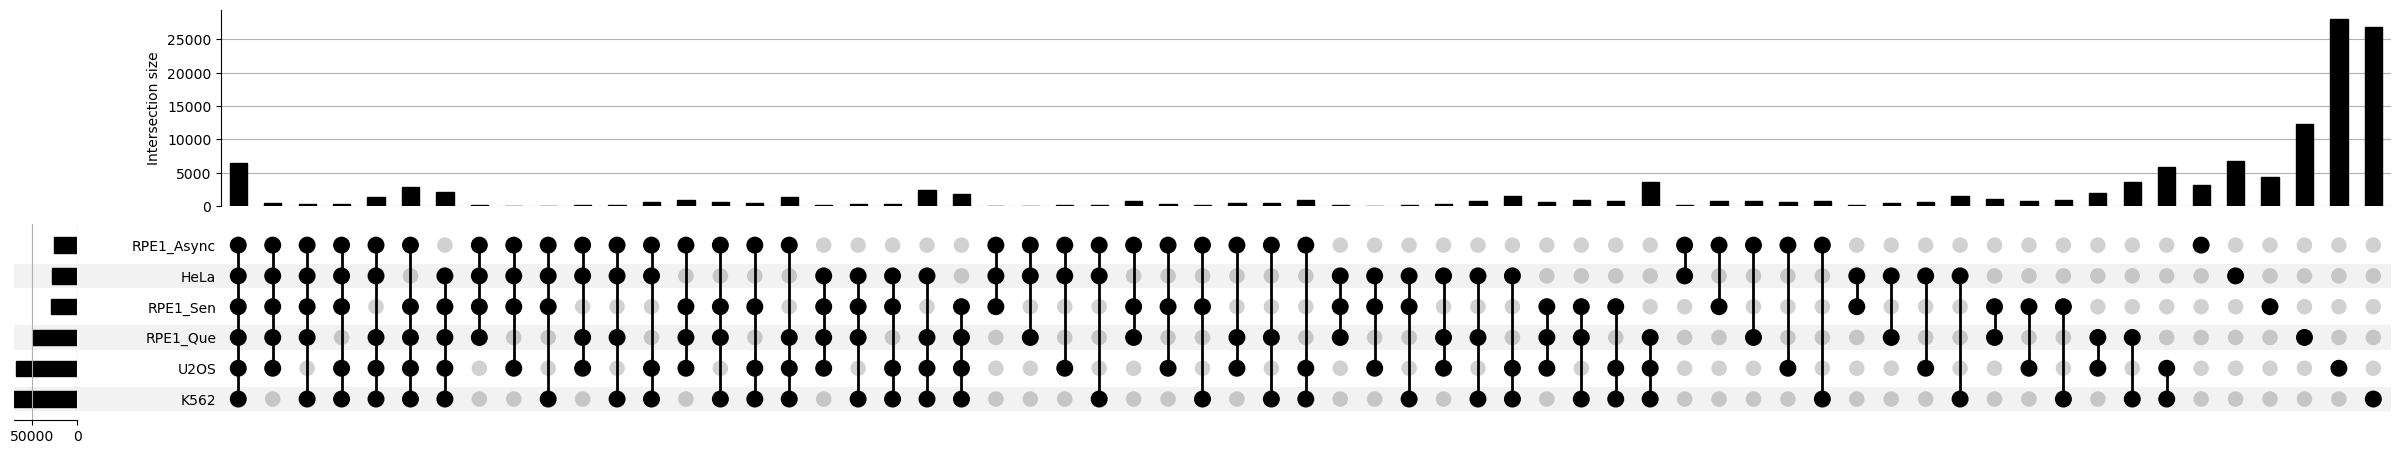

In [42]:
upsetplot.plot(
    upsetplot.from_memberships(memberships).groupby(level=[0,1,2,3,4,5]).sum(), sort_by='-degree'
)

In [43]:
wide_canonical_to_noncanonical_transcript = pd.concat({
    'Canonical': canonical_transcript_translation_norm_count_matrix.reindex_like(any_transcript_translation_norm_count_matrix).fillna(0),
    'Non-canonical': noncanonical_transcript_translation_norm_count_matrix.reindex_like(any_transcript_translation_norm_count_matrix).fillna(0)
})

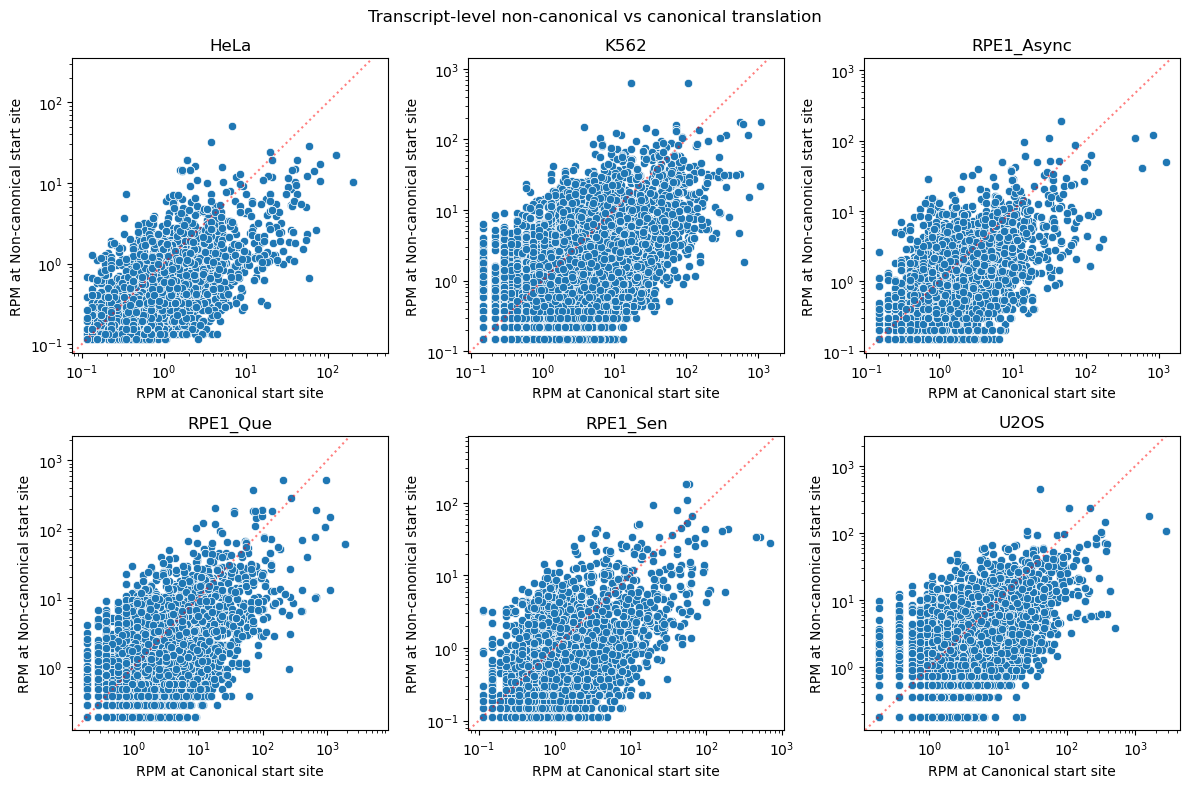

In [44]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.flatten()

for i, s in enumerate(samples):
    df = wide_canonical_to_noncanonical_transcript.loc[pd.IndexSlice[:, s], :].droplevel(1, axis=0).T
    df = df[df.sum(axis=1) > 0]
    sns.scatterplot(
        df, x='Canonical', y='Non-canonical', ax=axs[i], zorder=0
    )
    # sns.kdeplot(
    #     df, x='Canonical', y='Non-canonical', color='tab:red', ax=axs[i]
    # )
    axs[i].axline((0,0), slope=1, linestyle='dotted', color='red', alpha=0.5, zorder=1)
    axs[i].set_xlabel('RPM at Canonical start site')
    axs[i].set_ylabel('RPM at Non-canonical start site')
    axs[i].set_xscale('log', base=10)
    axs[i].set_yscale('log', base=10)
    axs[i].set_title(s)
plt.suptitle('Transcript-level non-canonical vs canonical translation')
plt.tight_layout()
plt.show()

In [122]:
# NaNs reflect no TIS at any site detected in that cell line; zeroes reflect TISs at non-canonical start sites but not canonical in that cell line
gene_level_tis_ratios = canonical_transcript_count_fraction.T.merge(
    tis_annotation_df[['Tid', 'Symbol']], left_index=True, right_on='Tid'
).groupby('Symbol')[samples].mean()

In [147]:
sns.color_palette('tab10')[:6]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)]

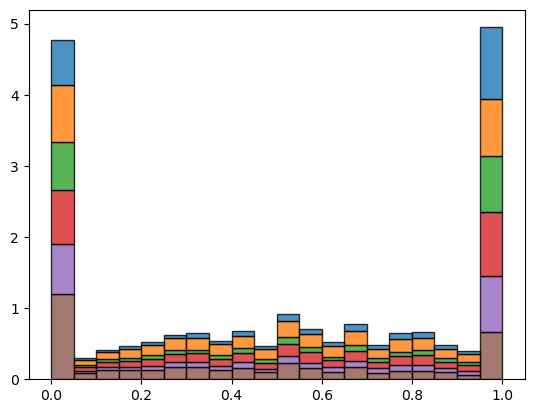

In [152]:
hist = plt.hist([gene_level_tis_ratios.loc[:, s].dropna().tolist() for s in samples[::-1]], bins = np.linspace(0, 1, 21), 
    stacked=True, density=True, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'][::-1], edgecolor='black', alpha=0.8
)

### Canonical counts conditional on upstream start codons

In [172]:
paired_tis_df = all_tis_df[~all_tis_df['RecatTISType'].isin(['Annotated'])].drop_duplicates(subset=['Sample', 'Tid']).merge(
    all_tis_df[all_tis_df['RecatTISType'] == 'Annotated'].drop_duplicates(subset=['Sample', 'Tid'])[
        ['Sample', 'Tid', 'Start', 'StartCodon', 'TISCounts', 'NormTISCounts']
    ].rename({'Start':'CanonicalStart', 'StartCodon':'CanonicalStartCodon', 'TISCounts':'CanonicalTISCounts', 'NormTISCounts':'CanonicalNormTISCounts'}, axis=1)
)
paired_tis_df['RelativeCountsToCanonical'] = (paired_tis_df['TISCounts']+1) / (paired_tis_df['CanonicalTISCounts']+1)
paired_tis_df['DistanceToCanonical'] = (paired_tis_df['CanonicalStart'] - paired_tis_df['Start']).abs()

<Axes: xlabel='DistanceToCanonical', ylabel='RelativeCountsToCanonical'>

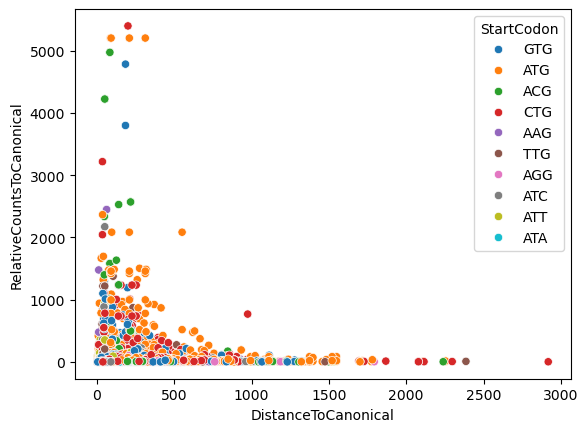

In [174]:
sns.scatterplot(
    paired_tis_df[paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])],
    x='DistanceToCanonical', y='RelativeCountsToCanonical',
    hue='StartCodon'
)

<Axes: xlabel='StartCodon', ylabel='RelativeCountsToCanonical'>

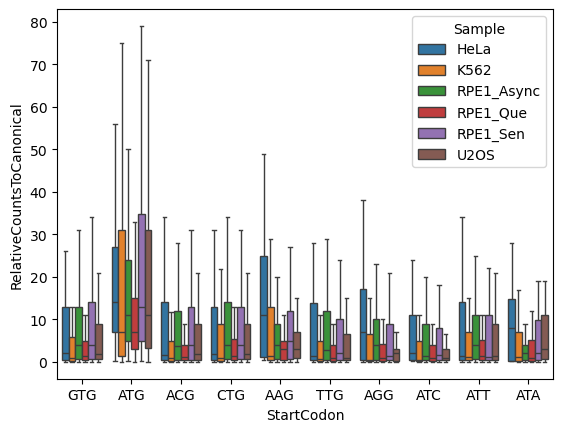

In [177]:
sns.boxplot(
    paired_tis_df[paired_tis_df['RecatTISType'].isin(['Extended', 'uORF'])],
    x='StartCodon', y='RelativeCountsToCanonical', hue='Sample', showfliers=False
)

## Are we overcounting start sites?

In [84]:
all_tis_df.columns

Index(['Sample', 'Gid', 'Tid', 'Symbol', 'GeneType', 'GenomePos', 'Start',
       'StartCodon', 'TisType', 'RecatTISType', 'TISGroup', 'TISCounts',
       'NormTISCounts', 'AALen', 'MANE_Select', 'transcript_support_level',
       'Imputed', 'AASeq', 'GenomeStart', 'IsoformID', 'TIS_ID'],
      dtype='str')

In [86]:
all_tis_df.groupby(
    ['Sample', 'Gid', 'GenomeStart', 'TISCounts'])[
        ['Tid', 'TisType', 'RecatTISType', 'Start', 'AALen']
    ].agg(lambda x: '|'.join(list(x.astype(str))))

Tid  \
Sample Gid                GenomeStart    TISCounts                                                      
HeLa   ENSG00000000003.17 chrX:100636694 98         2|3|5|9|0| | | | |E|N|S|T|0|0|0|0|0|3|7|3|0|2|...   
       ENSG00000000419.15 chr20:50935135 0          2|7|6|6|5| | | | | |E|N|S|T|0|0|0|0|0|3|7|1|5|...   
                          chr20:50958514 35         2|2|1|7|0| | | | | |E|N|S|T|0|0|0|0|0|3|7|1|5|...   
       ENSG00000000460.18 chr1:169795102 20         1|9|2|9| | | | |E|N|S|T|0|0|0|0|0|4|9|6|9|7|3|...   
       ENSG00000001036.15 chr6:143511634 307        8|4|3|8| | | | |E|N|S|T|0|0|0|0|0|0|0|2|1|6|5|...   
...                                                                                               ...   
U2OS   ENSG00000310517.2  chr5:96662422  50         2|1|8|5|2|3| | | | |E|N|S|T|0|0|0|0|0|6|7|5|1|...   
                          chr5:96663136  18         2|1|8|5|2|5| | | | |E|N|S|T|0|0|0|0|0|5|0|8|6|...   
                          chr5:96722677  30         2|1|8|5|2|1| | | | |E|N|S|T|0|0|0|0|0|5|0|5|1|...   
       ENSG00000310560.2  chr9:136992443 14         2|2|9|5|7|1| | | | |E|N|S|T|0|0|0|0|0|4|8|1|1|...   
       ENSG00000310576.1  chr19:1275549  20         2|5|2|3|5|4| | | | |E|N|S|T|0|0|0|0|0|4|0|9|2|...   

                                                                                              TisType  \
Sample Gid                GenomeStart    TISCounts                                                      
HeLa   ENSG00000000003.17 chrX:100636694 98         2|3|5|9|0| | | | |A|n|n|o|t|a|t|e|d|\n|N|a|m|e...   
       ENSG00000000419.15 chr20:50935135 0          2|7|6|6|5| | | | |A|n|n|o|t|a|t|e|d|\n|2|7|6|6...   
                          chr20:50958514 35         2|2|1|7|0| | | | |T|r|u|n|c|a|t|e|d|\n|2|2|1|7...   
       ENSG00000000460.18 chr1:169795102 20         1|9|2|9| | | | |A|n|n|o|t|a|t|e|d|\n|N|a|m|e|:...   
       ENSG00000001036.15 chr6:143511634 307        8|4|3|8| | | | |A|n|n|o|t|a|t|e|d|\n|N|a|m|e|:...   
...                                                                                               ...   
U2OS   ENSG00000310517.2  chr5:96662422  50         2|1|8|5|2|3| | | | |A|n|n|o|t|a|t|e|d|\n|N|a|m...   
                          chr5:96663136  18         2|1|8|5|2|5| | | | |A|n|n|o|t|a|t|e|d|\n|N|a|m...   
                          chr5:96722677  30         2|1|8|5|2|1| | | | | | | | | | |A|n|n|o|t|a|t|...   
       ENSG00000310560.2  chr9:136992443 14         2|2|9|5|7|1| | | | |N|o|v|e|l|:|K|n|o|w|n|\n|N...   
       ENSG00000310576.1  chr19:1275549  20         2|5|2|3|5|4| | | | |A|n|n|o|t|a|t|e|d|\n|N|a|m...   

                                                                                         RecatTISType  \
Sample Gid                GenomeStart    TISCounts                                                      
HeLa   ENSG00000000003.17 chrX:100636694 98         2|3|5|9|0| | | | |A|n|n|o|t|a|t|e|d|\n|N|a|m|e...   
       ENSG00000000419.15 chr20:50935135 0          2|7|6|6|5| | | | |A|n|n|o|t|a|t|e|d|\n|2|7|6|6...   
                          chr20:50958514 35         2|2|1|7|0| | | | |T|r|u|n|c|a|t|e|d|\n|2|2|1|7...   
       ENSG00000000460.18 chr1:169795102 20         1|9|2|9| | | | |A|n|n|o|t|a|t|e|d|\n|N|a|m|e|:...   
       ENSG00000001036.15 chr6:143511634 307        8|4|3|8| | | | |A|n|n|o|t|a|t|e|d|\n|N|a|m|e|:...   
...                                                                                               ...   
U2OS   ENSG00000310517.2  chr5:96662422  50         2|1|8|5|2|3| | | | |A|n|n|o|t|a|t|e|d|\n|N|a|m...   
                          chr5:96663136  18         2|1|8|5|2|5| | | | |A|n|n|o|t|a|t|e|d|\n|N|a|m...   
                          chr5:96722677  30         2|1|8|5|2|1| | | | |A|n|n|o|t|a|t|e|d|\n|2|1|8...   
       ENSG00000310560.2  chr9:136992443 14         2|2|9|5|7|1| | | | |O|t|h|e|r|\n|N|a|m|e|:| |R...   
       ENSG00000310576.1  chr19:1275549  20         2|5|2|3|5|4| | | | |A|n|n|o|t|a|t|e|d|\n|N|a|m...   



# MYC uORFs?

In [45]:
LOAD_SEQUENCES = True
sequences = ['AASeq'] #['Seq', 'AASeq']

sample_to_dropped_tis = dict()
samples = experiment_table['sample'].tolist()

for sample in tqdm(samples):
    filt_table = pd.read_csv(experiment_table.set_index('sample').loc[sample, 'dropped_file'])

    # # add undetected canonical start codons
    # imputed_table = impute_missing_canonical_starts(
    #     filt_table, 
    #     genome_pos=transcript_to_genome_pos, 
    #     utr_lengths=transcript_to_utr_length, 
    #     start_codons=transcript_to_start_codon,
    #     protein_products=transcript_to_protein
    # )

    # # combine with the detected TISs
    # filt_table = pd.concat([
    #     filt_table, imputed_table
    # ], axis=0, ignore_index=True)
    # filt_table['Imputed'] = filt_table['Imputed'].fillna(False)

    # if LOAD_SEQUENCES:
    #     pred_table = pd.read_csv(experiment_table.set_index('sample').loc[sample, 'predict_file'], sep='\t', usecols=['Tid', 'GenomePos', 'Start'] + sequences)
    #     # pull AA translations for the non-canonical TISs from the ribotish outputs
    #     merged_table = filt_table.merge(pred_table, left_on=['Tid', 'GenomePos', 'Start'], right_on=['Tid', 'GenomePos', 'Start'], how='left')

    #     # pull AA translations for the canonical TISs from the protein annotations
    #     merged_table.loc[
    #         merged_table['Imputed'], 'AASeq'
    #     ] = transcript_to_protein.set_index('Tid').reindex(
    #         index=merged_table[merged_table['Imputed']]['Tid'].tolist()
    #     )['AASeq'].tolist()
    # else:
    #     merged_table = filt_table
    sample_to_dropped_tis[sample] = filt_table
all_dropped_tis_df= pd.concat(sample_to_dropped_tis, axis=0).reset_index(names=['Sample', 'drop']).drop(['drop'], axis=1)

100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


In [46]:
og_hela_ribotish = pd.read_csv('/lab/barcheese01/aTIS_data/ribotish/combined/HeLa_TIS_predict_all.txt', sep='\t')

In [195]:
og_hela_ribotish[(og_hela_ribotish['Symbol'] == 'MYC') & (og_hela_ribotish['TisType'].str.contains('UTR|Extended|Novel'))].sort_values('GenomePos')

,Gid,Tid,Symbol,GeneType,GenomePos,StartCodon,Start,Stop,TisType,TISGroup,...,TISPvalue,RiboPvalue,RiboPStatus,FisherPvalue,TISQvalue,FrameQvalue,FisherQvalue,AALen,Seq,AASeq
231354,ENSG00000136997.22,ENST00000259523.10,MYC,protein_coding,chr8:127736244-127736286:+,ATT,811,853,5'UTR,6,...,0.013439,2.245992e-02,T,2.748380e-03,1.000000,3.729404e-01,3.549029e-01,13,ATTCCAGCGAGAGGCAGAGGGAGCGAGCGGGCGGCCGGCTAG,IPARGRGSERAAG*
231361,ENSG00000136997.22,ENST00000377970.6,MYC,protein_coding,chr8:127736244-127736286:+,ATT,161,203,5'UTR,6,...,0.013439,2.245992e-02,T,2.748380e-03,1.000000,3.729404e-01,3.549029e-01,13,ATTCCAGCGAGAGGCAGAGGGAGCGAGCGGGCGGCCGGCTAG,IPARGRGSERAAG*
231364,ENSG00000136997.22,ENST00000524013.2,MYC,protein_coding,chr8:127736244-127736286:+,ATT,25,67,5'UTR,6,...,0.013439,2.245992e-02,T,2.748380e-03,1.000000,3.729404e-01,3.549029e-01,13,ATTCCAGCGAGAGGCAGAGGGAGCGAGCGGGCGGCCGGCTAG,IPARGRGSERAAG*
231371,ENSG00000136997.22,ENST00000621592.8,MYC,protein_coding,chr8:127736244-127736286:+,ATT,14,56,5'UTR,5,...,0.002381,2.245992e-02,T,5.795988e-04,0.982343,3.729404e-01,8.543892e-02,13,ATTCCAGCGAGAGGCAGAGGGAGCGAGCGGGCGGCCGGCTAG,IPARGRGSERAAG*
231365,ENSG00000136997.22,ENST00000621592.8,MYC,protein_coding,chr8:127736590-127740958:+,ACG,360,1728,Extended,5,...,0.016845,5.162926e-14,N,3.102970e-14,1.000000,7.424638e-12,2.396731e-11,455,ACGCTGGATTTTTTTCGGGTAGTGGAAAACCAGCAGCCTCCCGCGA...,TLDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEEN...
231352,ENSG00000136997.22,ENST00000259523.10,MYC,protein_coding,chr8:127736593-127740414:+,CTG,1160,1979,Extended:Known,6,...,0.000248,2.652673e-08,L,1.758210e-10,0.151467,1.444847e-06,7.853886e-08,272,CTGGATTTTTTTCGGGTAGTGGAAAACCAGCAGCCTCCCGCGACGA...,LDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENF...
231359,ENSG00000136997.22,ENST00000377970.6,MYC,protein_coding,chr8:127736593-127740958:+,CTG,510,1875,Extended:Known,6,...,0.000248,4.792349e-14,L,4.746797e-16,0.151467,6.925334e-12,4.682121e-13,454,CTGGATTTTTTTCGGGTAGTGGAAAACCAGCAGCCTCCCGCGACGA...,LDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENF...
231392,ENSG00000136997.22,ENST00000707117.1,MYC,protein_coding,chr8:127740532-127740958:+,AGG,897,1323,Novel:CDSFrameOverlap,4,...,0.012218,1.766155e-05,L,3.528040e-06,1.000000,5.672431e-04,7.772678e-04,141,AGGTGCCACGTCTCCACACATCAGCACAACTACGCAGCGCCTCCCT...,RCHVSTHQHNYAAPPSTRKDYPAAKRVKLDSVRVLRQISNNRKCTS...
231393,ENSG00000136997.22,ENST00000707117.1,MYC,protein_coding,chr8:127740877-127740958:+,ATT,1242,1323,Novel:CDSFrameOverlap,4,...,0.010062,2.992461e-02,N,2.742556e-03,1.000000,4.756247e-01,3.542148e-01,26,ATTTCTGAAGAGGACTTGTTGCGGAAACGACGAGAACAGTTGAAAC...,ISEEDLLRKRREQLKHKLEQLRNSCA*


In [190]:
all_tis_df[(all_tis_df['Symbol'] == 'MYC') & (all_tis_df['RecatTISType'] == 'Extended')]

,Sample,Gid,Tid,Symbol,GeneType,GenomePos,Start,StartCodon,TisType,RecatTISType,TISGroup,TISCounts,NormTISCounts,AALen,MANE_Select,transcript_support_level,Imputed,AASeq,TIS_ID
10244,HeLa,ENSG00000136997.22,ENST00000259523.10,MYC,protein_coding,chr8:127736593-127740414:+,1160.0,CTG,Extended:Known,Extended,6,97,1.857254,272.0,False,1.0,False,LDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENF...,ENST00000259523.10:1160.0
10246,HeLa,ENSG00000136997.22,ENST00000377970.6,MYC,protein_coding,chr8:127736593-127740958:+,510.0,CTG,Extended:Known,Extended,6,97,1.857254,454.0,False,1.0,False,LDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENF...,ENST00000377970.6:510.0
55045,K562,ENSG00000136997.22,ENST00000259523.10,MYC,protein_coding,chr8:127736593-127740414:+,1160.0,CTG,Extended:Known,Extended,7,1220,45.037341,272.0,False,1.0,False,LDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENF...,ENST00000259523.10:1160.0
55051,K562,ENSG00000136997.22,ENST00000377970.6,MYC,protein_coding,chr8:127736593-127740958:+,510.0,CTG,Extended:Known,Extended,7,1220,45.037341,454.0,False,1.0,False,LDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENF...,ENST00000377970.6:510.0
107537,RPE1_Async,ENSG00000136997.22,ENST00000259523.10,MYC,protein_coding,chr8:127736593-127740414:+,1160.0,CTG,Extended:Known,Extended,5,105,5.194076,272.0,False,1.0,False,LDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENF...,ENST00000259523.10:1160.0
107540,RPE1_Async,ENSG00000136997.22,ENST00000377970.6,MYC,protein_coding,chr8:127736593-127740958:+,510.0,CTG,Extended:Known,Extended,5,105,5.194076,454.0,False,1.0,False,LDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENF...,ENST00000377970.6:510.0
142905,RPE1_Que,ENSG00000136997.22,ENST00000259523.10,MYC,protein_coding,chr8:127736593-127740414:+,1160.0,CTG,Extended:Known,Extended,2,15,1.404121,272.0,False,1.0,False,LDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENF...,ENST00000259523.10:1160.0
142910,RPE1_Que,ENSG00000136997.22,ENST00000377970.6,MYC,protein_coding,chr8:127736593-127740958:+,510.0,CTG,Extended:Known,Extended,2,15,1.404121,454.0,False,1.0,False,LDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENF...,ENST00000377970.6:510.0
183788,RPE1_Sen,ENSG00000136997.22,ENST00000259523.10,MYC,protein_coding,chr8:127736593-127740414:+,1160.0,CTG,Extended:Known,Extended,5,62,2.332174,272.0,False,1.0,False,LDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENF...,ENST00000259523.10:1160.0
183792,RPE1_Sen,ENSG00000136997.22,ENST00000377970.6,MYC,protein_coding,chr8:127736593-127740958:+,510.0,CTG,Extended:Known,Extended,5,62,2.332174,454.0,False,1.0,False,LDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENF...,ENST00000377970.6:510.0


In [189]:
all_dropped_tis_df[(all_dropped_tis_df['Symbol'] == 'MYC') & (all_dropped_tis_df['RecatTISType'] == 'Extended')]

,Sample,Gid,Tid,Symbol,GeneType,GenomePos,Start,StartCodon,TisType,RecatTISType,TISGroup,TISCounts,NormTISCounts,AALen,MANE_Select,transcript_support_level,DropReason
221117,HeLa,ENSG00000136997.22,ENST00000621592.8,MYC,protein_coding,chr8:127736590-127740958:+,360,ACG,Extended,Extended,5,28,0.536115,455,True,1.0,NotSignificant
1545064,RPE1_Async,ENSG00000136997.22,ENST00000651626.1,MYC,protein_coding,chr8:127738289-127740958:+,188,AGG,Extended:CDSFrameOverlap,Extended,3,9,0.445207,430,False,NaN,NotReferenceTranscript
1545065,RPE1_Async,ENSG00000136997.22,ENST00000651626.1,MYC,protein_coding,chr8:127738556-127740958:+,455,CTG,Extended:CDSFrameOverlap,Extended,3,4,0.197870,341,False,NaN,NotReferenceTranscript|NotSignificant
1545094,RPE1_Async,ENSG00000136997.22,ENST00000707115.1,MYC,protein_coding,chr8:127738130-127740958:+,394,ATA,Extended,Extended,3,4,0.197870,483,False,NaN,NotReferenceTranscript|NotSignificant
2113380,RPE1_Que,ENSG00000136997.22,ENST00000707115.1,MYC,protein_coding,chr8:127738130-127740958:+,394,ATA,Extended,Extended,1,2,0.187216,483,False,NaN,NotReferenceTranscript|NotSignificant
2113381,RPE1_Que,ENSG00000136997.22,ENST00000707115.1,MYC,protein_coding,chr8:127738217-127740958:+,481,CTG,Extended,Extended,1,2,0.187216,454,False,NaN,NotReferenceTranscript|NotSignificant
3353498,U2OS,ENSG00000136997.22,ENST00000651626.1,MYC,protein_coding,chr8:127738289-127740958:+,188,AGG,Extended:CDSFrameOverlap,Extended,3,8,0.732893,430,False,NaN,NotReferenceTranscript|NotSignificant
3353538,U2OS,ENSG00000136997.22,ENST00000707115.1,MYC,protein_coding,chr8:127738130-127740958:+,394,ATA,Extended,Extended,3,4,0.366447,483,False,NaN,NotReferenceTranscript|NotSignificant
3353539,U2OS,ENSG00000136997.22,ENST00000707115.1,MYC,protein_coding,chr8:127738160-127740958:+,424,GTG,Extended,Extended,3,4,0.366447,473,False,NaN,NotReferenceTranscript|NotSignificant
3353540,U2OS,ENSG00000136997.22,ENST00000707115.1,MYC,protein_coding,chr8:127738217-127740958:+,481,CTG,Extended,Extended,3,4,0.366447,454,False,NaN,NotReferenceTranscript|NotSignificant


In [187]:
all_dropped_tis_df[(all_dropped_tis_df['Symbol'] == 'MYC') & (all_dropped_tis_df['RecatTISType'] == 'uORF')]

,Sample,Gid,Tid,Symbol,GeneType,GenomePos,Start,StartCodon,TisType,RecatTISType,TISGroup,TISCounts,NormTISCounts,AALen,MANE_Select,transcript_support_level,DropReason
221109,HeLa,ENSG00000136997.22,ENST00000259523.10,MYC,protein_coding,chr8:127736244-127736286:+,811,ATT,5'UTR,uORF,6,45,0.861613,13,False,1.0,NotSignificant
221114,HeLa,ENSG00000136997.22,ENST00000377970.6,MYC,protein_coding,chr8:127736244-127736286:+,161,ATT,5'UTR,uORF,6,45,0.861613,13,False,1.0,NotSignificant
221116,HeLa,ENSG00000136997.22,ENST00000524013.2,MYC,protein_coding,chr8:127736244-127736286:+,25,ATT,5'UTR,uORF,6,45,0.861613,13,False,1.0,NotSignificant
221121,HeLa,ENSG00000136997.22,ENST00000621592.8,MYC,protein_coding,chr8:127736244-127736286:+,14,ATT,5'UTR,uORF,5,45,0.861613,13,True,1.0,NotSignificant
852747,K562,ENSG00000136997.22,ENST00000259523.10,MYC,protein_coding,chr8:127736486-127736612:+,1053,ACG,5'UTR:CDSFrameOverlap,uORF,7,138,5.094388,41,False,1.0,NotSignificant
852748,K562,ENSG00000136997.22,ENST00000259523.10,MYC,protein_coding,chr8:127736513-127736612:+,1080,ATT,5'UTR:CDSFrameOverlap,uORF,7,82,3.027100,32,False,1.0,NotSignificant
852749,K562,ENSG00000136997.22,ENST00000259523.10,MYC,protein_coding,chr8:127736562-127738279:+,1129,CTG,5'UTR,uORF,7,114,4.208407,30,False,1.0,NotSignificant
852750,K562,ENSG00000136997.22,ENST00000259523.10,MYC,protein_coding,chr8:127736178-127736232:+,745,ACG,5'UTR,uORF,7,40,1.476634,17,False,1.0,NotSignificant
852751,K562,ENSG00000136997.22,ENST00000259523.10,MYC,protein_coding,chr8:127736190-127736232:+,757,ATC,5'UTR,uORF,7,114,4.208407,13,False,1.0,UpstreamTIS
852752,K562,ENSG00000136997.22,ENST00000259523.10,MYC,protein_coding,chr8:127736287-127736353:+,854,GTG,5'UTR,uORF,7,1036,38.244824,21,False,1.0,NotSignificant


In [188]:
all_dropped_tis_df[(all_dropped_tis_df['Symbol'] == 'MYC') & (all_dropped_tis_df['RecatTISType'] == 'Extended')]

,Sample,Gid,Tid,Symbol,GeneType,GenomePos,Start,StartCodon,TisType,RecatTISType,TISGroup,TISCounts,NormTISCounts,AALen,MANE_Select,transcript_support_level,DropReason
221117,HeLa,ENSG00000136997.22,ENST00000621592.8,MYC,protein_coding,chr8:127736590-127740958:+,360,ACG,Extended,Extended,5,28,0.536115,455,True,1.0,NotSignificant
1545064,RPE1_Async,ENSG00000136997.22,ENST00000651626.1,MYC,protein_coding,chr8:127738289-127740958:+,188,AGG,Extended:CDSFrameOverlap,Extended,3,9,0.445207,430,False,NaN,NotReferenceTranscript
1545065,RPE1_Async,ENSG00000136997.22,ENST00000651626.1,MYC,protein_coding,chr8:127738556-127740958:+,455,CTG,Extended:CDSFrameOverlap,Extended,3,4,0.197870,341,False,NaN,NotReferenceTranscript|NotSignificant
1545094,RPE1_Async,ENSG00000136997.22,ENST00000707115.1,MYC,protein_coding,chr8:127738130-127740958:+,394,ATA,Extended,Extended,3,4,0.197870,483,False,NaN,NotReferenceTranscript|NotSignificant
2113380,RPE1_Que,ENSG00000136997.22,ENST00000707115.1,MYC,protein_coding,chr8:127738130-127740958:+,394,ATA,Extended,Extended,1,2,0.187216,483,False,NaN,NotReferenceTranscript|NotSignificant
2113381,RPE1_Que,ENSG00000136997.22,ENST00000707115.1,MYC,protein_coding,chr8:127738217-127740958:+,481,CTG,Extended,Extended,1,2,0.187216,454,False,NaN,NotReferenceTranscript|NotSignificant
3353498,U2OS,ENSG00000136997.22,ENST00000651626.1,MYC,protein_coding,chr8:127738289-127740958:+,188,AGG,Extended:CDSFrameOverlap,Extended,3,8,0.732893,430,False,NaN,NotReferenceTranscript|NotSignificant
3353538,U2OS,ENSG00000136997.22,ENST00000707115.1,MYC,protein_coding,chr8:127738130-127740958:+,394,ATA,Extended,Extended,3,4,0.366447,483,False,NaN,NotReferenceTranscript|NotSignificant
3353539,U2OS,ENSG00000136997.22,ENST00000707115.1,MYC,protein_coding,chr8:127738160-127740958:+,424,GTG,Extended,Extended,3,4,0.366447,473,False,NaN,NotReferenceTranscript|NotSignificant
3353540,U2OS,ENSG00000136997.22,ENST00000707115.1,MYC,protein_coding,chr8:127738217-127740958:+,481,CTG,Extended,Extended,3,4,0.366447,454,False,NaN,NotReferenceTranscript|NotSignificant


TIS_ID                   TisType  
ENST00000000233.10:88.0  Annotated    6
ENST00000000412.8:116.0  5'UTR        2
ENST00000000412.8:159.0  Annotated    6
ENST00000000412.8:3.0    5'UTR        4
ENST00000000412.8:33.0   5'UTR        3
                                     ..
ENST00000715679.1:49.0   Truncated    1
ENST00000715679.1:55.0   Truncated    1
ENST00000715679.1:85.0   Truncated    1
ENST00000718285.1:79.0   Novel        1
ENST00000850956.1:252.0  Novel        1
Name: Sample, Length: 136563, dtype: int64

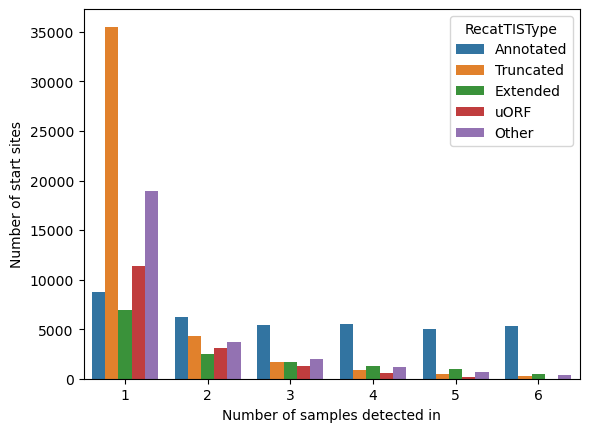

In [213]:
sns.countplot(
    all_tis_df.groupby(['TIS_ID', 'RecatTISType'])['Sample'].nunique().reset_index(),
    x='Sample', hue='RecatTISType'
)
plt.xlabel('Number of samples detected in')
plt.ylabel('Number of start sites')
plt.savefig('/lab/barcheese01/smaffa/coTISja/data/figures/start_site_uniqueness.png')

In [205]:
all_tis_df.groupby(['TIS_ID'])['Sample'].nunique().reset_index()

,TIS_ID,Sample
0,ENST00000000233.10:88.0,6
1,ENST00000000412.8:116.0,2
2,ENST00000000412.8:159.0,6
3,ENST00000000412.8:3.0,4
4,ENST00000000412.8:33.0,3
...,...,...
136558,ENST00000715679.1:49.0,1
136559,ENST00000715679.1:55.0,1
136560,ENST00000715679.1:85.0,1
136561,ENST00000718285.1:79.0,1


In [ ]:
all_tis_df.value_counts('TIS_ID', 'Gid')

,Sample,Gid,Tid,Symbol,GeneType,GenomePos,Start,StartCodon,TisType,RecatTISType,TISGroup,TISCounts,NormTISCounts,AALen,MANE_Select,transcript_support_level,Imputed,AASeq,TIS_ID
0,HeLa,ENSG00000188976.12,ENST00000327044.7,NOC2L,protein_coding,chr1:944693-959240:-,16.0,ATG,Annotated,Annotated,3,16,0.306351,749.0,True,1.0,False,MAAAGSRKRRLAELTVDEFLASGFDSESESESENSPQAETREAREA...,ENST00000327044.7:16.0
1,HeLa,ENSG00000188976.12,ENST00000487214.1,NOC2L,protein_coding,chr1:954456-959219:-,90.0,AAG,Novel:CDSFrameOverlap,Other,4,54,1.033935,247.0,False,3.0,False,KRRLAELTVDEFLASGFDSESESESENSPQAETREAREAARSPDKP...,ENST00000487214.1:90.0
2,HeLa,ENSG00000187608.11,ENST00000624697.4,ISG15,protein_coding,chr1:1013998-1014478:+,245.0,GTG,Extended:CDSFrameOverlap,Extended,2,10,0.191470,159.0,False,3.0,False,VKMLAGNEFQVSLSSSMSVSELKAQITQKIGVHAFQQRLAVHPSGV...,ENST00000624697.4:245.0
3,HeLa,ENSG00000187608.11,ENST00000624652.1,ISG15,protein_coding,chr1:1013998-1014433:+,220.0,GTG,Extended:CDSFrameOverlap,Extended,2,10,0.191470,145.0,False,3.0,False,VKMLAGNEFQVSLSSSMSVSELKAQITQKIGVHAFQQRLAVHPSGV...,ENST00000624652.1:220.0
4,HeLa,ENSG00000187608.11,ENST00000649529.1,ISG15,protein_coding,chr1:1013546-1014478:+,50.0,GTG,Extended,Extended,3,49,0.938201,174.0,True,NaN,False,VAHSPQPTAMGWDLTVKMLAGNEFQVSLSSSMSVSELKAQITQKIG...,ENST00000649529.1:50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270095,U2OS,ENSG00000269335.8,ENST00000612051.1,IKBKG,protein_coding,chrX:154542264-154552007:+,1.0,ATG,Annotated,Annotated,0,0,0.000000,48.0,False,1.0,True,MALVIQVGKLRPREVRTPQTINPSLFPSLPVKLSSIIEVPSALALLDE,ENST00000612051.1:1.0
270096,U2OS,ENSG00000130826.20,ENST00000369550.10,DKC1,protein_coding,chrX:154762966-154776864:+,102.0,ATG,Annotated,Annotated,0,0,0.000000,514.0,True,1.0,True,MADAEVIILPKKHKKKKERKSLPEEDVAEIQHAEEFLIKPESKVAK...,ENST00000369550.10:102.0
270097,U2OS,ENSG00000130830.16,ENST00000413259.7,MPP1,protein_coding,chrX:154799756-154779180:-,393.0,ATG,Annotated,Annotated,0,0,0.000000,436.0,False,2.0,True,MESWAVSHPLNTVTEDMYTNGSPAPGSPAQVKGQEVRKVRLIQFEK...,ENST00000413259.7:393.0
270098,U2OS,ENSG00000155959.13,ENST00000535916.5,VBP1,protein_coding,chrX:155208904-155238839:+,163.0,ATG,Annotated,Annotated,0,0,0.000000,192.0,False,2.0,True,MAPQPMIHTQQGLRTSSPSTPSPEHQEDVDSFMKQPGNETADTVLK...,ENST00000535916.5:163.0
